In [1]:
import pandas as pd
import numpy as np
import scipy
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from lightgbm import LGBMClassifier 
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, BaseEnsemble, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
import eli5
import shap
from sklearn import model_selection

pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000

In [2]:
data = pd.read_csv('../data/data_full_final.csv')

In [3]:
traincols = list(data.columns)
traincols.remove('RESULT')

In [4]:
train = pd.read_csv('../data/CAX_MortgageModeling_Train.csv')
train_len = train.shape[0]

In [7]:
train = data.iloc[:train_len]
test = data.iloc[train_len:]

In [5]:
import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Input

Using TensorFlow backend.


In [6]:
from sklearn.preprocessing import MinMaxScaler

In [8]:
for col in traincols:
    if train[col].nunique() == 1 or test[col].nunique() == 1:
        print (col)
        traincols.remove(col)

FSA_A2
FSA_B6
FSA_C4
FSA_E5
FSA_G7
FSA_M0
FSA_M7
FSA_R4
FSA_R6
FSA_W1
AMORTIZATION_60
INCOME TYPE_20


In [9]:
clf = MinMaxScaler(feature_range=(0,1))
data_scaled = clf.fit_transform(data[traincols].values)

In [10]:
input_ = Input(shape=(len(traincols),))
layer1 = Dense(100,activation='relu')(input_)
layer2 = Dense(20,activation='relu')(layer1)
encoder = Model(input_,layer2)
layer3 = Dense(100,activation='relu')(layer2)
output = Dense(len(traincols),activation='relu')(layer3)
AE = Model(input_,output)
AE.compile(loss='mean_squared_error',optimizer='adam')
AE.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 701)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               70200     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               2100      
_________________________________________________________________
dense_4 (Dense)              (None, 701)               70801     
Total params: 145,121
Trainable params: 145,121
Non-trainable params: 0
_________________________________________________________________


In [15]:
AE.fit(data_scaled[data.RESULT == 1],data_scaled[data.RESULT == 1],epochs=100,verbose=2,validation_split=.1)

Train on 8657 samples, validate on 962 samples
Epoch 1/100
 - 1s - loss: 0.0147 - val_loss: 0.0147
Epoch 2/100
 - 1s - loss: 0.0147 - val_loss: 0.0147
Epoch 3/100
 - 1s - loss: 0.0147 - val_loss: 0.0147
Epoch 4/100
 - 1s - loss: 0.0147 - val_loss: 0.0147
Epoch 5/100
 - 1s - loss: 0.0146 - val_loss: 0.0147
Epoch 6/100
 - 1s - loss: 0.0146 - val_loss: 0.0147
Epoch 7/100
 - 1s - loss: 0.0146 - val_loss: 0.0146
Epoch 8/100
 - 1s - loss: 0.0146 - val_loss: 0.0146
Epoch 9/100
 - 1s - loss: 0.0146 - val_loss: 0.0147
Epoch 10/100
 - 1s - loss: 0.0146 - val_loss: 0.0146
Epoch 11/100
 - 1s - loss: 0.0146 - val_loss: 0.0146
Epoch 12/100
 - 1s - loss: 0.0146 - val_loss: 0.0146
Epoch 13/100
 - 1s - loss: 0.0146 - val_loss: 0.0146
Epoch 14/100
 - 1s - loss: 0.0146 - val_loss: 0.0146
Epoch 15/100
 - 1s - loss: 0.0145 - val_loss: 0.0146
Epoch 16/100
 - 1s - loss: 0.0145 - val_loss: 0.0139
Epoch 17/100
 - 1s - loss: 0.0138 - val_loss: 0.0138
Epoch 18/100
 - 1s - loss: 0.0137 - val_loss: 0.0138
Epoch 19

In [16]:
train_scaled = data_scaled[:train_len,:]
test_scaled = data_scaled[train_len:,:]

In [17]:
train_embeddings = encoder.predict(train_scaled)
test_embeddings = encoder.predict(test_scaled)

In [18]:
train_embeddings = pd.DataFrame(train_embeddings,columns=["AE_{}".format(i+1) for i in range(20)])
test_embeddings = pd.DataFrame(test_embeddings,columns=["AE_{}".format(i+1) for i in range(20)])

In [19]:
train_embeddings['RESULT'] = train.RESULT

In [20]:
train_embeddings.head(10)

,AE_1,AE_2,AE_3,AE_4,AE_5,AE_6,AE_7,AE_8,AE_9,AE_10,AE_11,AE_12,AE_13,AE_14,AE_15,AE_16,AE_17,AE_18,AE_19,AE_20,RESULT
0,4.346986,1.380236,0.0,3.195754,2.393371,3.078811,0.0,5.626407,2.582938,2.647582,2.691206,0.0,0.0,0.0,2.900299,1.668898,0.0,0.0,0.0,3.547074,0.0
1,2.483893,1.496898,0.0,4.878686,2.148301,2.341609,0.0,5.406716,4.373258,1.367733,2.951184,0.0,0.0,0.0,3.621839,4.977972,0.0,0.0,0.0,1.820436,0.0
2,3.231698,2.609103,0.0,3.242928,3.932862,1.725142,0.0,3.019469,4.777946,2.747082,4.497034,0.0,0.0,0.0,1.658315,1.128857,0.0,0.0,0.0,3.190166,0.0
3,2.292125,3.154967,0.0,5.496627,2.609830,3.914622,0.0,3.754990,3.272496,3.704294,3.415001,0.0,0.0,0.0,3.227544,0.357678,0.0,0.0,0.0,2.600900,0.0
4,3.090448,2.950884,0.0,3.323071,1.907173,2.770014,0.0,5.519004,4.147541,3.449484,0.912723,0.0,0.0,0.0,2.532791,2.816134,0.0,0.0,0.0,2.841352,0.0
5,3.629452,2.509977,0.0,1.860817,2.890054,1.085693,0.0,4.654540,5.169764,1.675355,1.986889,0.0,0.0,0.0,1.091969,1.592290,0.0,0.0,0.0,3.856692,0.0
6,1.843323,1.717963,0.0,4.046533,4.258569,2.976836,0.0,5.105686,3.929281,1.752260,3.377820,0.0,0.0,0.0,3.025788,4.756861,0.0,0.0,0.0,3.527513,0.0
7,3.197797,2.702501,0.0,4.032144,3.240292,3.302272,0.0,4.159964,3.385545,2.076706,1.990918,0.0,0.0,0.0,3.346430,1.766180,0.0,0.0,0.0,1.868057,0.0
8,3.266018,2.584610,0.0,2.784538,3.942747,1.047251,0.0,4.307391,5.391067,2.397680,1.691484,0.0,0.0,0.0,2.436023,2.253331,0.0,0.0,0.0,3.209840,1.0
9,3.195916,2.244209,0.0,6.115583,3.507011,2.807461,0.0,2.934849,2.643453,3.312875,4.105257,0.0,0.0,0.0,2.331913,3.037223,0.0,0.0,0.0,1.940416,0.0


In [21]:
for col in ["AE_{}".format(i+1) for i in range(20)]:
    if train_embeddings[col].nunique() == 1:
        train_embeddings = train_embeddings.drop([col],axis=1)
        test_embeddings = test_embeddings.drop([col],axis=1)

In [22]:
train_embeddings.head(10)

,AE_1,AE_2,AE_4,AE_5,AE_6,AE_8,AE_9,AE_10,AE_11,AE_15,AE_16,AE_20,RESULT
0,4.346986,1.380236,3.195754,2.393371,3.078811,5.626407,2.582938,2.647582,2.691206,2.900299,1.668898,3.547074,0.0
1,2.483893,1.496898,4.878686,2.148301,2.341609,5.406716,4.373258,1.367733,2.951184,3.621839,4.977972,1.820436,0.0
2,3.231698,2.609103,3.242928,3.932862,1.725142,3.019469,4.777946,2.747082,4.497034,1.658315,1.128857,3.190166,0.0
3,2.292125,3.154967,5.496627,2.609830,3.914622,3.754990,3.272496,3.704294,3.415001,3.227544,0.357678,2.600900,0.0
4,3.090448,2.950884,3.323071,1.907173,2.770014,5.519004,4.147541,3.449484,0.912723,2.532791,2.816134,2.841352,0.0
5,3.629452,2.509977,1.860817,2.890054,1.085693,4.654540,5.169764,1.675355,1.986889,1.091969,1.592290,3.856692,0.0
6,1.843323,1.717963,4.046533,4.258569,2.976836,5.105686,3.929281,1.752260,3.377820,3.025788,4.756861,3.527513,0.0
7,3.197797,2.702501,4.032144,3.240292,3.302272,4.159964,3.385545,2.076706,1.990918,3.346430,1.766180,1.868057,0.0
8,3.266018,2.584610,2.784538,3.942747,1.047251,4.307391,5.391067,2.397680,1.691484,2.436023,2.253331,3.209840,1.0
9,3.195916,2.244209,6.115583,3.507011,2.807461,2.934849,2.643453,3.312875,4.105257,2.331913,3.037223,1.940416,0.0


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

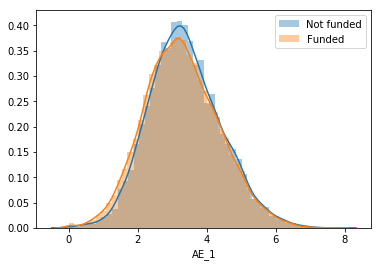

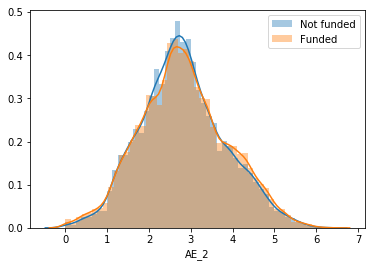

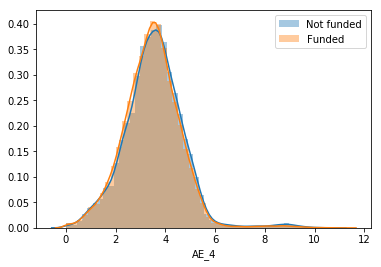

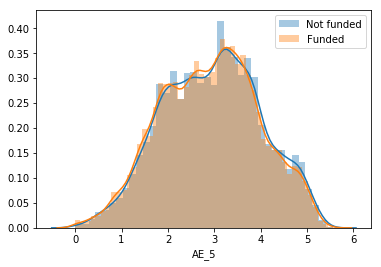

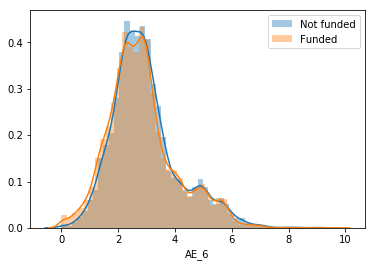

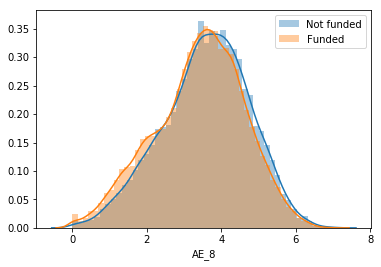

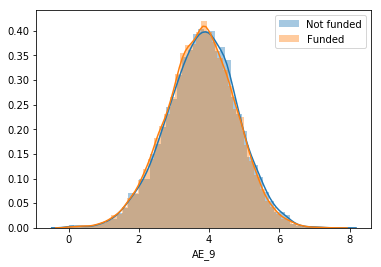

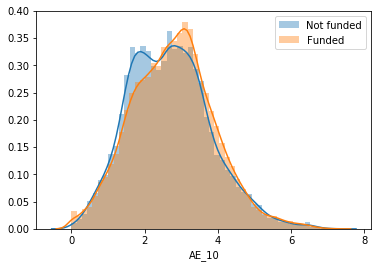

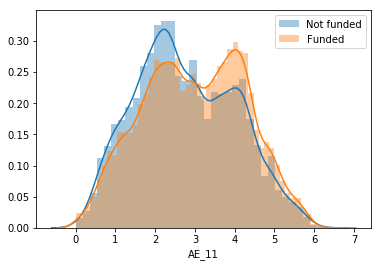

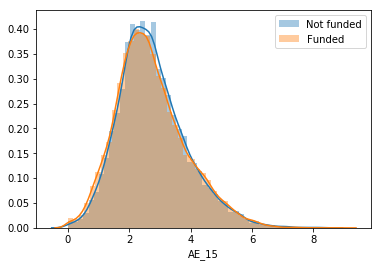

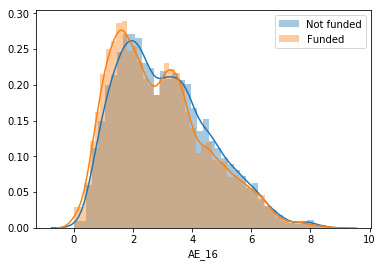

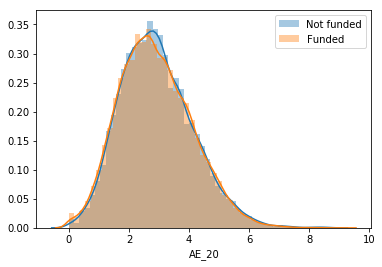

In [24]:
for col in train_embeddings.columns:
    if col != 'RESULT':
        sns.distplot(train_embeddings[train_embeddings.RESULT == 1][col],kde=True,label='Not funded')
        sns.distplot(train_embeddings[train_embeddings.RESULT == 0][col],kde=True,label='Funded')
        plt.xlabel(col)
        plt.legend()
        plt.show()

In [25]:
for col in train_embeddings.columns:
    if col != 'RESULT':
        d1 = train_embeddings[train_embeddings.RESULT == 1][col]
        d2 = train_embeddings[train_embeddings.RESULT == 0][col]
        p_value = scipy.stats.ttest_ind(d1,d2).pvalue
        print (col, p_value)

AE_1 9.289609584570165e-16
AE_2 0.04059990474853981
AE_4 1.397717326296902e-11
AE_5 3.220541557289277e-05
AE_6 2.667618407945367e-19
AE_8 1.2499081924169029e-37
AE_9 9.584538358148161e-06
AE_10 4.942951173475215e-13
AE_11 5.037727072951915e-52
AE_15 0.0002120301861933222
AE_16 3.017648279496102e-25
AE_20 0.019031684255865718


In [26]:
train_embeddings = train_embeddings.drop(['RESULT'],axis=1)
train_embeddings.to_csv('../data/train_AE_embeddings.csv',index=False)
test_embeddings.to_csv('../data/test_AE_embeddings.csv',index=False)